In this notebook we will be using the smtd_preprocessing.py file which is a preprocessing pileline for twitter data to pre-process our tweets and then train our own twitter embeddings. <br>
We can find pre-trained twitter embedding 


In [ ]:
#!pip install demoji

In [5]:
'''
Contains helper funtions for preprocessing of twitter documents before getting their corresponding vectors
from word2vec_twitter model
Author: Anuj Gupta
'''

'''
functionality:
Discard non-english tweets
Discard Replies
Discard RTs
For now this is handle while fetch tweet text from mongo documents
process constantbrands mentions
process any other mentions
process constant brand name if any 
process hanstags
process URLs
process websites
process process_EmailIds
process 
process alphanums
'''
import re
import string
import demoji
demoji.download_codes()
from nltk.tokenize import TweetTokenizer

#gobal
PunctChars = r'''[`'“".?!,:;]'''
Punct = '%s+' % PunctChars
Entity = '&(amp|lt|gt|quot);'
printable = set(string.printable)

# helper functoins
def regex_or(*items):
	r = '|'.join(items)
	r = '(' + r + ')'
	return r

def pos_lookahead(r):
	return '(?=' + r + ')'

def neg_lookahead(r):
	return '(?!' + r + ')'

def optional(r):
	return '(%s)?' % r

def trim(transient_tweet_text):
	''' 
	trim leading and trailing spaces in the tweet text
	'''
	return transient_tweet_text.strip()

def strip_whiteSpaces(transient_tweet_text):
	'''
	Strip all white spaces
	'''
	transient_tweet_text = re.sub(r'[\s]+', ' ', transient_tweet_text)
	return transient_tweet_text

def to_LowerCase(transient_tweet_text):
	'''
	Convert tweet text to lower to lower case alphabets
	'''
	transient_tweet_text = transient_tweet_text.lower()
	return transient_tweet_text

def prune_multple_consecutive_same_char(transient_tweet_text):
	'''
	yesssssssss  is converted to yess 
	ssssssssssh is converted to ssh
	'''
	transient_tweet_text = re.sub(r'(.)\1+', r'\1\1', transient_tweet_text)
	return transient_tweet_text

def remove_spl_words(transient_tweet_text):
	transient_tweet_text = transient_tweet_text.replace('&amp;',' and ')

	return transient_tweet_text

def strip_unicode(transient_tweet_text):
    '''
    Strip all unicode characters from a tweet
    '''
    tweet = ''.join(i for i in transient_tweet_text if ord(i)<128)
    return tweet 

def process_URLs(transient_tweet_text):
	'''
	replace all URLs in the tweet text
	'''
	UrlStart1 = regex_or('https?://', r'www\.',r'bit.ly/')
	CommonTLDs = regex_or('com','co\\.uk','org','net','info','ca','biz','info','edu','in','au')
	UrlStart2 = r'[a-z0-9\.-]+?' + r'\.' + CommonTLDs + pos_lookahead(r'[/ \W\b]')
	UrlBody = r'[^ \t\r\n<>]*?'  # * not + for case of:  "go to bla.com." -- don't want period
	UrlExtraCrapBeforeEnd = '%s+?' % regex_or(PunctChars, Entity)
	UrlEnd = regex_or( r'\.\.+', r'[<>]', r'\s', '$')
	Url = 	(optional(r'\b') + 
    		regex_or(UrlStart1, UrlStart2) + 
    		UrlBody + 
    pos_lookahead( optional(UrlExtraCrapBeforeEnd) + UrlEnd))

	Url_RE = re.compile("(%s)" % Url, re.U|re.I)
	transient_tweet_text = re.sub(Url_RE, " constanturl ", transient_tweet_text)

	# fix to handle unicodes in URL
	URL_regex2 = r'\b(htt)[p\:\/]*([\\x\\u][a-z0-9]*)*'
	transient_tweet_text = re.sub(URL_regex2, " constanturl ", transient_tweet_text)
	return transient_tweet_text

def process_Websites(transient_tweet_text):
	'''
	identify website mentioned if any 
	'''
	CommonTLDs = regex_or('com','co\\.uk','org','net','info','ca','biz','info','edu','in','au')
	sep = r'[.]'
	website_regex = r'(?<!#)?(\b)?[a-zA-Z0-9.]+' + sep + CommonTLDs
	website_RE = re.compile("(%s)" % website_regex, re.U|re.I)
	transient_tweet_text = re.sub(website_RE, ' constantwebsite ', transient_tweet_text)

	return transient_tweet_text

def process_EmailIds(transient_tweet_text):
	'''
	identify email mentioned if any
	'''
	email_regex = r'(\b)?[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(\b)?'
	transient_tweet_text = re.sub(email_regex, ' constantemailid ', transient_tweet_text)

	return transient_tweet_text

def process_Mentions(transient_tweet_text):
	'''
	Identify mentions if any
	'''
	transient_tweet_text = re.sub(r"@(\w+)", " constantnonbrandmention ", transient_tweet_text)
	return transient_tweet_text
def process_HashTags(transient_tweet_text):
	'''
	Strip all Hashtags from a tweet
	'''
	transient_tweet_text = re.sub(r"#(\w+)\b", ' constanthashtag ', transient_tweet_text)
	return transient_tweet_text

def process_Dates(transient_tweet_text):
	'''
	Identify date and convert it to constant
	'''
	#transient_tweet_text = re.sub(r'(\d+/\d+/\d+)', " constantdate " , transient_tweet_text)
	#transient_tweet_text = re.sub(r'constantnum[\s]?(/|-)[\s]?constantnum[\s]?(/|-)[\s]?constantnum', " constantdate " , transient_tweet_text)
	#date_regex = r'(constantnum)[\s]*(st|nd|rd|th)[\s]*(january|jan|february|feb|march|mar|april|may|june|jun|july|august|aug|september|sep|october|oct|november|nov|december|dec)'
	date_regex1 = r'\b((0|1|2|3)?[0-9][\s]*)[-./]([\s]*([012]?[0-9])[\s]*)([-./]([\s]*(19|20)[0-9][0-9]))?\b'
	transient_tweet_text = re.sub(date_regex1, ' constantdate ' , transient_tweet_text)
	date_regex2 = r'\b((19|20)[0-9][0-9][\s]*[-./]?)?[\s]*([012]?[0-9])[\s]*[-./][\s]*(0|1|2|3)?[0-9]\b'
	transient_tweet_text = re.sub(date_regex2, ' constantdate ' , transient_tweet_text)

	Months = regex_or('january','jan','february','feb','march','mar','april','may','june','jun','july','jul','august','aug','september','sep','october','oct','november','nov','december','dec')
	date_regex3 = r'\d+[\s]*(st|nd|rd|th)[\s]*' + Months 
	transient_tweet_text = re.sub(date_regex3, ' constantdate ', transient_tweet_text)
	date_regex4 = Months + r'[\s]*\d+[\s]*(st|nd|rd|th)*\b'
	transient_tweet_text = re.sub(date_regex4, ' constantdate ' , transient_tweet_text)
	date_regex5 = r'[\s]?\b(19|20)[0-9][0-9]\b[\s]?'
	transient_tweet_text = re.sub(date_regex5, ' constantdate ' , transient_tweet_text)

	date_regex6 = r'([\s]*(constantdate))+'
	transient_tweet_text = re.sub(date_regex6, ' constantdate ' , transient_tweet_text)

	return transient_tweet_text

def process_Times(transient_tweet_text):
	'''
	Indentify time and convert it to constant
	'''
	time_regex1 = r'([0-9]|0[0-9]|1[0-9]|2[0-3]):[0-5][0-9][\s]*(am|pm)?[\s]*([iescm](st)|gmt|utc|[pmce](dt))?'
	transient_tweet_text = re.sub(time_regex1, ' constanttime ' , transient_tweet_text)

	return transient_tweet_text

def process_BrandMentions(transient_tweet_text):
	'''
	process all airrwoot brands Mentions if any in tweet text
	'''
	constant_brands = regex_or('paytmcare', 'paytm','snapdeal_help','snapdeal','bluestone_com','shopohelp','shopo','mobikwikswat',
		'mobikwik','taxiforsure','tfscares','zoomcarindia','freshmenuindia','freshmenucares','grofers','jetairways',
		'cleartrip','olacabs','support_ola','makemytrip','makemytripcare','chai_point')

	BrandMentionRegex = r'@(\b)*' + constant_brands
	transient_tweet_text = re.sub(BrandMentionRegex, ' constantbrandmention ', transient_tweet_text)
	return transient_tweet_text

def process_NonBrandMentions(transient_tweet_text):
	'''
	process all Mentions left, if any, in tweet text
	'''
	transient_tweet_text = re.sub(r"@(\w+)", ' constantnonbrandmention ', transient_tweet_text)
	return transient_tweet_text

def process_BrandName(transient_tweet_text):
	'''
	process all airrwoot brands Mentions if any in tweet text
	'''
	constant_brands = regex_or('paytmcare', 'paytm','snapdeal_help','snapdeal','bluestone_com', 'bluestone','shopohelp','shopo',
		'mobikwikswat','mobikwik','taxiforsure','tfscares', 'tfs','zoomcarindia', 'zoomcar','freshmenuindia','freshmenucares', 
		'freshmenu','grofers','jetairways', 'jet','cleartrip','olacabs','support_ola', 'olacab', 'ola' ,'makemytrip',
		'makemytripcare', 'chai_point')

	BrandNameRegex = constant_brands
	transient_tweet_text = re.sub(BrandNameRegex, ' constantbrandname ', transient_tweet_text)
	return transient_tweet_text

def identify_Savings(transient_tweet_text):
	'''
	identify sale/save offers
	'''
	#sale_regex = r'(?<!#)\b(discount|discounts|sale|save|saver|super[\s]*saver|super[\s]*save)\b[\s]*(constantnum)*[\s]*[%]?[\s]*(-|~)?[\s]*(constantnum)*[\s]*[%]?'
	sale_regex = r'(?<!#)\b(discount|discounts|sale|save|saver|super[\s]*saver|super[\s]*save)\b[\s]*((rs|\$)*[\s]*(constantnum))*[\s]*[%]?[\s]*(-|~|or)?[\s]*((rs|\$)*[\s]*(constantnum))*[\s]*[%]?'
	transient_tweet_text = re.sub(sale_regex, " constantdiscount ", transient_tweet_text)
	#discount_List = []
	#discount_List = re.findall(r'constantdiscount', transient_tweet_text)
	return transient_tweet_text

def indentify_Offers(transient_tweet_text):
	'''
	identify cashbacks and off / substrings of the form "30% off" or "30% cashback" or "$30 off"
	Replace them by constantOFFER
	'''
	#transient_tweet_text = re.sub(r'[rs|$]?[ ]*[constantnum][ ]*[%]?[ ]?[off|cashback|offer]', "constantoffer", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:(up[\s]?to)?((rs|\$)*[\s]*(constantnum))[\s]*[%]?)?[\s]*[-|~|or]?[\.]?[\s]*((rs|\$)*[\s]*(constantnum))*[\s]*[%]?[\s]*(offer|off|cashback|cash|cash back)', " constantoffer ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:cashback|cash back|cash)\b', " constantoffer ", transient_tweet_text)
	#Offer_List = []
	#Offer_List = re.findall(r'constantoffer', transient_tweet_text)
	return transient_tweet_text

def indentify_Promos(transient_tweet_text):
	'''
	indentify coupons/promos with promo codes
	Assumption - promo code can be alphanumeric. But it immediately follows text of promo/code/promocode etc
	'''
	#transient_tweet_text = re.sub(r'\b(promocode|promo code|promo|code)[s]?[\s]*[a-z]*(constantnum)*[a-z]*[\s]+', " constantpromo ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:promocode|promo code|promo|coupon code|code)\b[\s]*(constantalphanum)\b', " constantpromo ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:promocode|promo code|promo|coupon code|code)\b[\s]*[a-z]+\b', " constantpromo ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:promocode|promo code|promo|coupon code|code)\b[\s]*[0-9]+\b', " constantpromo ", transient_tweet_text)
	transient_tweet_text = re.sub(r'(?<!#)\b(?:promocode|promo code|promo|coupon code|code|coupon)[s]?\b', " constantpromo ", transient_tweet_text)
	#Promo_List = []
	#Promo_List = re.findall(r'constantpromo', transient_tweet_text)
	return transient_tweet_text

def indentify_Money(transient_tweet_text):
	'''
	identify money in the tweet text but outside offers. This includes $,Rs, pound, Euro
	'''
	money_regex1 = r'\b(rs|\$)[\s]*(constantnum)?[\.]?[\s]*constantnum\b'
	transient_tweet_text = re.sub(money_regex1, " constantmoney ", transient_tweet_text)
	money_regex2 = r'[\s]*[\.]?[\s]*constantnum(cent[s]?|\$|c)\b'
	transient_tweet_text = re.sub(money_regex2, " constantmoney ", transient_tweet_text)
	money_regex3 = r'(\$|rs)[\s]*constantalphanum'
	transient_tweet_text = re.sub(money_regex3, " constantmoney ", transient_tweet_text)
	#Money_List = []
	#Money_List = re.findall(r'constantmoney', transient_tweet_text)
	return transient_tweet_text

def indentify_freebies(transient_tweet_text):
	'''
	indentify freebies in tweets if any - free offers, free shipping, free trial, 
	'''
	freebies_regex1 = r'(?<!#)\b(?:free)[\s]+[a-z]+\b'
	transient_tweet_text = re.sub(freebies_regex1, " constantfreebies ", transient_tweet_text)
	freebies_regex2 = r'(?<!#)\b(?:free)[\s]+[a-z]*\b'
	transient_tweet_text = re.sub(freebies_regex2, " constantfreebies ", transient_tweet_text)
	return transient_tweet_text

def replace_numbers(transient_tweet_text):
	'''
	Given any number/interger in tweet text, we want it to be replaced by constantnum
	'''
	# we want to process only those numbers that are not in a hashtag - below logic does this
	num_regex = r'(?<!#)\b(?:[-+]?[\d,]*[\.]?[\d,]*[\d]+|\d+)\b'
	transient_tweet_text = re.sub(num_regex, " constantnum " , transient_tweet_text)
	return transient_tweet_text

def identify_AlphaNumerics(transient_tweet_text):
	'''
	Identify alpha numerics - this helps in identifying product codes/models, promocodes, Order IDs
	'''
	AlphaNumeric_regex = r'(?<!#)\b(?:([a-z]+[0-9]+[a-z]*|[a-z]*[0-9]+[a-z]+)[a-z,0-9]*)\b'
	transient_tweet_text = re.sub(AlphaNumeric_regex, " constantalphanum ", transient_tweet_text)
	return transient_tweet_text

def strip_whiteSpaces(transient_tweet_text):
	'''
	Strip all white spaces
	'''
	transient_tweet_text = re.sub(r'[\s]+', ' ', transient_tweet_text)
	return transient_tweet_text

def prune_multple_consecutive_same_char(transient_tweet_text):
	'''
	yesssssssss  is converted to yess 
	ssssssssssh is converted to ssh
	'''
	transient_tweet_text = re.sub(r'(.)\1+', r'\1\1', transient_tweet_text)
	return transient_tweet_text

def remove_spl_words(transient_tweet_text):
	transient_tweet_text = transient_tweet_text.replace('&amp;',' and ')

	return transient_tweet_text

def remove_emoji(transient_tweet_text):
    tweet_tokenizer = TweetTokenizer()
    tokenized_tweet = tweet_tokenizer.tokenize(transient_tweet_text)
    emojis_present = demoji.findall(transient_tweet_text)
    tweet_no_emoji=''
    for i,s in enumerate(tokenized_tweet):
        if s in emojis_present.keys():
            tweet_no_emoji = tweet_no_emoji + ' ' + emojis_present[s]
        else:
            tweet_no_emoji = tweet_no_emoji + ' ' + s
    return tweet_no_emoji

def deEmojify(transient_tweet_text):
    return transient_tweet_text.encode('ascii', 'ignore').decode('ascii')

# def print_test():
    
#     test_tweet = "Nice @varun paytm @paytm saver abc@gmail.com sizes for the wolf on 20/10/2010 at 10:00PM  grey/deep royal-volt Nike Air Skylon II retro are 40% OFF for a limited time at $59.99 + FREE shipping.BUY HERE -> https://bit.ly/2L2n7rB (promotion - use code MEMDAYSV at checkout)"
#     #General Proprocessing
#     test_tweet = test_tweet.lower()
#     test_tweet = strip_unicode(test_tweet)
    
#     #function tests
#     print("Process URLS:\n",process_URLs(test_tweet))
#     print("Remove websites:\n",process_Websites(test_tweet))
#     print("Remove mentions:\n",process_Mentions(test_tweet))
#     print('Remove Emailid:\n',process_EmailIds(test_tweet))
#     print("Remove Hashtags:\n",process_HashTags(test_tweet))
#     print("Remove Dates:\n",process_Dates(test_tweet))
#     print("Process Time:\n",process_Times(test_tweet))
#     print("Process Brand Mention:\n",process_BrandMentions(test_tweet))
#     print("Process non Brand Mention:\n",process_NonBrandMentions(test_tweet))
#     print("Process Brand Name:\n",process_BrandName(test_tweet))
#     print("Process Savings:\n",identify_Savings(test_tweet))
#     print("Process Offers:\n",indentify_Offers(test_tweet))
#     print("Identiy Promos:\n",indentify_Promos(test_tweet))
# ############
# print_test()




def process_TweetText(tweet_text):
	'''
	Takes tweet_text and preprocesses it 
	Order of preprocessing:
	'''

	# get utf-8 encoding, lowercase, trim and remove multiple white spaces
	transient_tweet_text = tweet_text
	transient_tweet_text = strip_unicode(transient_tweet_text)
	#print "PROCESSED: ", transient_tweet_text

	transient_tweet_text = to_LowerCase(transient_tweet_text)
	transient_tweet_text = trim(transient_tweet_text)
	transient_tweet_text = strip_whiteSpaces(transient_tweet_text)
	transient_tweet_text = remove_spl_words(transient_tweet_text)

 
	#emoji
	transient_tweet_text = remove_emoji(transient_tweet_text) 
	transient_tweet_text = deEmojify(transient_tweet_text)
	# process Hastags, URLs, Websites, process_EmailIds
	# Give precedence to url over hashtag
	transient_tweet_text = process_URLs(transient_tweet_text)
	transient_tweet_text = process_HashTags(transient_tweet_text)
	#transient_tweet_text = process_Websites(transient_tweet_text)
	transient_tweet_text = process_EmailIds(transient_tweet_text)

	# process for brand mention, any other mention and brand Name
	#transient_tweet_text = process_BrandMentions(transient_tweet_text)
	#transient_tweet_text = process_NonBrandMentions(transient_tweet_text)
	transient_tweet_text = process_Mentions(transient_tweet_text)
	#transient_tweet_text = process_BrandName(transient_tweet_text)

	# remove any unicodes
	transient_tweet_text = strip_unicode(transient_tweet_text)

	# identify Date / Time if any
	transient_tweet_text = process_Times(transient_tweet_text)
	transient_tweet_text = process_Dates(transient_tweet_text)

	# indentify alphanums and nums
	transient_tweet_text = identify_AlphaNumerics(transient_tweet_text)
	transient_tweet_text = replace_numbers(transient_tweet_text)
	
	# identify promos, savings, offers, money and freebies
	transient_tweet_text = indentify_Promos(transient_tweet_text)
	transient_tweet_text = identify_Savings(transient_tweet_text)
	transient_tweet_text = indentify_Offers(transient_tweet_text)
	transient_tweet_text = indentify_Money(transient_tweet_text)
	transient_tweet_text = indentify_freebies(transient_tweet_text)

	transient_tweet_text = trim(transient_tweet_text)
	transient_tweet_text = strip_whiteSpaces(transient_tweet_text)

	transient_tweet_text = prune_multple_consecutive_same_char(transient_tweet_text)

	return transient_tweet_text

# if __name__ == "__main__":
# print(process_TweetText("Nice @varun paytm @paytm saver abc@gmail.com sizes for the wolf on 20/10/2010 at 10:00PM  grey/deep royal-volt Nike Air Skylon II retro are 40% OFF for a limited time at $59.99 + FREE shipping.BUY HERE -> https://bit.ly/2L2n7rB (promotion - use code MEMDAYSV at checkout)"))

... OK (Got response in 0.09 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [14]:
import os
import sys
import pandas as pd
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()
# /content/drive/My Drive/Data/NLP/Practical_NLP_Oreilly/Chap8/O5_smtd_preprocessing.py
#PATH = "/content/drive/My Drive/Data/NLP"
#preprocessing_path = PATH+"/practical-nlp/Ch8/O5_smtd_preprocessing.py"
#sys.path.append(os.path.abspath(preprocessing_path))
#import O5_smtd_preprocessing.py


Let's use the dir() function to find all the properties and methods in the package.

In [33]:
#dir(smtd_preprocessing)

## Read Data
Let's read the data. Normally in csv files the values are separated by a ','.<br> In this case, it is separated by a ';' so we will specify the delimiter as ';'.

In [21]:
datapath = "/content/drive/My Drive/Data/NLP/Practical_NLP_Oreilly/Chap8/sts_gold_tweet.csv"
df = pd.read_csv(datapath,error_bad_lines=False,delimiter=";")

In [22]:
#let's have a loof at the dataset
df

,id,polarity,tweet
0,1467933112,0,the angel is going to miss the athlete this we...
1,2323395086,0,It looks as though Shaq is getting traded to C...
2,1467968979,0,@clarianne APRIL 9TH ISN'T COMING SOON ENOUGH
3,1990283756,0,drinking a McDonalds coffee and not understand...
4,1988884918,0,So dissapointed Taylor Swift doesnt have a Twi...
...,...,...,...
2029,1468049681,0,A king sized bed is nice but sad and lonely wi...
2030,2195475499,0,@breannalovesjb hurry up home!!!!! im dying wi...
2031,1996172176,0,"@jordanhowell lol only a PSP, had a game boy b..."
2032,2016105580,4,Good morning everyone! It is such a beautiful...


In [23]:
#pre-process tweets using our package 
df['tweet'] = df['tweet'].apply(lambda x: process_TweetText(x))
df['tweet'] = df['tweet'].apply(lambda x: tweet_tokenizer.tokenize(x))
tweets = df['tweet'].values

In [24]:
df

,id,polarity,tweet
0,1467933112,0,"[the, angel, is, going, to, miss, the, athlete..."
1,2323395086,0,"[it, looks, as, though, shaq, is, getting, tra..."
2,1467968979,0,"[constantnonbrandmention, constantdate, isn't,..."
3,1990283756,0,"[drinking, a, mcdonalds, coffee, and, not, und..."
4,1988884918,0,"[so, dissapointed, taylor, swift, doesnt, have..."
...,...,...,...
2029,1468049681,0,"[a, king, sized, bed, is, nice, but, sad, and,..."
2030,2195475499,0,"[constantnonbrandmention, hurry, up, home, !, ..."
2031,1996172176,0,"[constantnonbrandmention, lol, only, a, psp, ,..."
2032,2016105580,4,"[good, morning, everyone, !, it, is, such, a, ..."


In [25]:
tweets

array([list(['the', 'angel', 'is', 'going', 'to', 'miss', 'the', 'athlete', 'this', 'weekend']),
       list(['it', 'looks', 'as', 'though', 'shaq', 'is', 'getting', 'traded', 'to', 'cleveland', 'to', 'play', 'w', '/', 'lebron', '..', 'too', 'bad', 'for', 'suns', "'", 'fans', '.', 'the', 'big', 'cactus', 'is', 'no', 'more']),
       list(['constantnonbrandmention', 'constantdate', "isn't", 'coming', 'soon', 'enough']),
       ...,
       list(['constantnonbrandmention', 'lol', 'only', 'a', 'psp', ',', 'had', 'a', 'game', 'boy', 'but', 'my', 'cousin', 'lost', 'it', 'and', 'theres', 'a', 'constantalphanum', 'around']),
       list(['good', 'morning', 'everyone', '!', 'it', 'is', 'such', 'a', 'beautiful', 'day', 'here', 'in', 'new', 'england', '!']),
       list(['hey', 'guess', 'was', 'constantnonbrandmention', 'the', 'lakers', 'won', 'and', 'kobe', 'is', 'mvp', 'just', 'thought', 'i', 'would', 'tell', 'ya', 'haha'])],
      dtype=object)

## Train Embeddings
Let's train our own embeddings.

In [26]:
#CBOW
import time
start = time.time()
word2vec_tweet = Word2Vec(tweets,min_count=5, sg=0)
end = time.time()

print("CBOW Model Training Complete.\nTime taken for training is:{:.5f} sec ".format((end-start)))

CBOW Model Training Complete.
Time taken for training is:0.32781 sec 


In [27]:
#Summarize the loaded model
print("Summary of the model:",word2vec_tweet)

#Summarize vocabulary
words = list(word2vec_tweet.wv.vocab)
print("Small part of Vocabulary of our model:",words[:10])

#Acess vector for one word
print("Acess Vector for the word 'lol'",word2vec_tweet['lol'])

Summary of the model: Word2Vec(vocab=774, size=100, alpha=0.025)
Small part of Vocabulary of our model: ['the', 'is', 'going', 'to', 'miss', 'this', 'weekend', 'it', 'looks', 'as']
Acess Vector for the word 'lol' [ 0.20260532  0.04886612  0.2051585  -0.10084946  0.10975069 -0.2945481
 -0.42785788  0.2443475   0.09113026  0.22713132 -0.16435039 -0.14258121
 -0.02377715 -0.2113446   0.16831289 -0.00095501  0.00094437  0.03681901
  0.15719326 -0.13303438 -0.03201597  0.04275341  0.48630133  0.21650107
 -0.10725792  0.05550466  0.02331711 -0.0929945  -0.02337819  0.05544114
 -0.27861688  0.1810249   0.02205864 -0.27113444 -0.16161549  0.02455114
  0.12615003  0.36916468 -0.12089179  0.47414634  0.29086068  0.2336871
 -0.2605947  -0.10311491  0.0014012   0.06328831 -0.00832315 -0.0073355
  0.23444594 -0.32245064 -0.46687648  0.28232586  0.01535827  0.02534534
  0.25683498 -0.14131932  0.55957127 -0.28047884  0.3214987  -0.23506631
 -0.06853155 -0.20348443 -0.09714205 -0.14723246 -0.03443433

In [31]:
print(len(word2vec_tweet['lol']))

100


In [32]:
from gensim.models import Word2Vec, KeyedVectors #To load the model
import warnings
warnings.filterwarnings('ignore') #ignore any generated warnings

import numpy as np
import matplotlib.pyplot as plt #to generate the t-SNE plot
from sklearn.manifold import TSNE #scikit learn's TSNE

In [34]:
#Preprocessing our models vocabulary to make better visualizations
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

words_vocab= list(word2vec_tweet.wv.vocab)#all the words in the vocabulary. 
print("Size of Vocabulary:",len(words_vocab))
print("Few words in Vocabulary",words_vocab[:50])

#Let us remove the stop words from this it will help making the visualization cleaner
stopwords_en = stopwords.words('english')
words_vocab_without_sw = [word.lower() for word in words_vocab if not word in stopwords_en]
print("Size of Vocabulary without stopwords:",len(words_vocab_without_sw))
print("Few words in Vocabulary without stopwords",words_vocab_without_sw[:30])
#The size didnt reduce much after removing the stop words so lets try visualizing only a selected subset of words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Size of Vocabulary: 774
Few words in Vocabulary ['the', 'is', 'going', 'to', 'miss', 'this', 'weekend', 'it', 'looks', 'as', 'though', 'getting', 'play', 'w', '/', 'lebron', '..', 'too', 'bad', 'for', "'", 'fans', '.', 'big', 'no', 'more', 'constantnonbrandmention', 'constantdate', "isn't", 'coming', 'soon', 'enough', 'drinking', 'a', 'mcdonalds', 'coffee', 'and', 'not', 'why', 'someone', 'would', 'me', 'so', 'taylor', 'swift', 'doesnt', 'have', 'twitter', 'i', 'was']
Size of Vocabulary without stopwords: 654
Few words in Vocabulary without stopwords ['going', 'miss', 'weekend', 'looks', 'though', 'getting', 'play', 'w', '/', 'lebron', '..', 'bad', "'", 'fans', '.', 'big', 'constantnonbrandmention', 'constantdate', 'coming', 'soon', 'enough', 'drinking', 'mcdonalds', 'coffee', 'someone', 'would', 'taylor', 'swift', 'doesnt', 'twitter']


In [35]:
#With the increase in the amount of data, it becomes more and more difficult to visualize and interpret
#In practice, similar words are combined into groups for further visualization.

keys = ['weekend','twitter','mcdonalds','coffee']
embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2vec_tweet.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(word2vec_tweet[similar_word])
    embedding_clusters.append(embeddings)#apending access vector of all similar words
    word_clusters.append(words)#appending list of all smiliar words

In [36]:
print("Embedding clusters:",embedding_clusters[0][0])#Access vector of the first word only
print("Word Clousters:",word_clusters[:2])

Embedding clusters: [ 2.4326216e-01  5.0065245e-02  2.5238654e-01 -1.0988342e-01
  1.3505249e-01 -3.4932658e-01 -5.0414318e-01  2.9252890e-01
  1.0250327e-01  2.6160923e-01 -1.9617724e-01 -1.7287959e-01
 -3.0313669e-02 -2.4323712e-01  2.0293896e-01 -1.0289950e-03
  1.7187120e-04  5.0344214e-02  1.8421374e-01 -1.4998075e-01
 -4.4926606e-02  5.3359915e-02  5.6779546e-01  2.5019625e-01
 -1.2867926e-01  6.5002210e-02  2.3487709e-02 -1.0822689e-01
 -2.9671865e-02  6.8633996e-02 -3.3125824e-01  2.0707016e-01
  3.4349956e-02 -3.2638410e-01 -1.9057840e-01  3.1616777e-02
  1.4624505e-01  4.2859229e-01 -1.4600503e-01  5.5142540e-01
  3.3233154e-01  2.7051389e-01 -3.0255374e-01 -1.2813661e-01
 -3.0923034e-03  7.4152999e-02 -5.2501420e-03 -2.9173307e-03
  2.7505317e-01 -3.7503600e-01 -5.5084991e-01  3.3974084e-01
  1.6063854e-02  2.6229803e-02  3.0401424e-01 -1.7546389e-01
  6.5582824e-01 -3.2948890e-01  3.7277111e-01 -2.7522406e-01
 -7.4173920e-02 -2.3902924e-01 -1.1402270e-01 -1.7382260e-01
 -3.

## Visualization
We will visualize our embeddings using T-SNE. If you do not know aht T-SNE is or have forgotten please refer to Ch3 in the book. We will be using the T-SNE code previously introduced in a notebook from Ch3 which can be found [here](https://github.com/practical-nlp/practical-nlp/blob/master/Ch3/09_Visualizing_Embeddings_Using_TSNE.ipynb).

In [37]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape #geting the dimensions
tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=1500, random_state=2020) 
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2) #reshaping it into 2d so we can visualize it

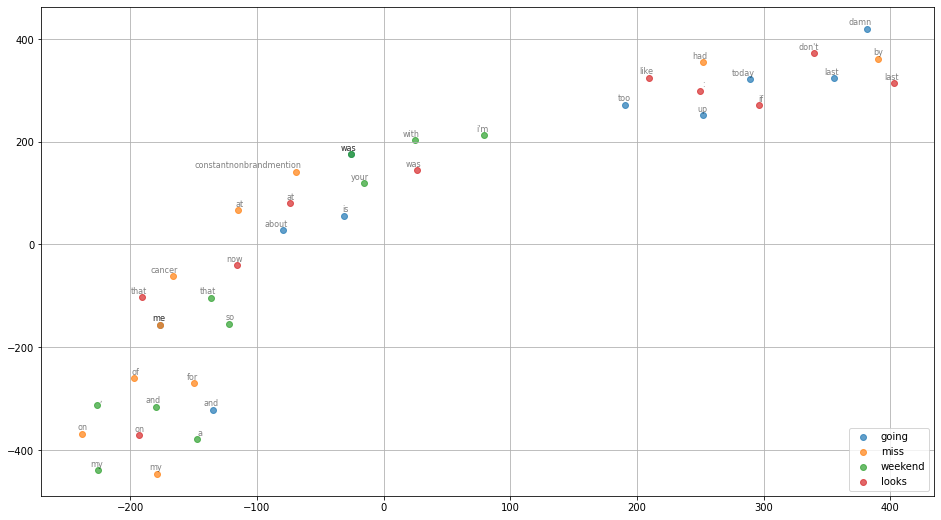

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline
#script for constructing two-dimensional graphics using Matplotlib
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    

    for label, embeddings, words in zip(labels, embedding_clusters, word_clusters):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

tsne_plot_similar_words(words_vocab_without_sw, embeddings_en_2d, word_clusters)